In [1]:
import io, chess,chess.pgn
import pandas as pd
import random
import time
import multiprocessing, os
from IPython.display import SVG, display
from tqdm import tqdm
import numpy as np

## Constants

In [2]:
BLACK = False 
WHITE = True

NUM_PROCESSES = 8
dark_diagonals = list(range(7,58,7)) # [8, 15, 22, 29, 36, 43, 50, 57]
light_diagonals = list(range(0,65,9)) # [1, 10, 19, 28, 37, 46, 55, 64]
both_diagonals = dark_diagonals + light_diagonals
center_squares = [27, 28, 35, 36]

piece_vals = {chess.PAWN:1, chess.BISHOP:3, chess.KNIGHT:3, chess.ROOK:5, chess.QUEEN:9}

In [65]:
mg_value = (82, 337, 365, 477, 1025,  0)

mg_pawn_table = (
      0,   0,   0,   0,   0,   0,  0,   0,
     98, 134,  61,  95,  68, 126, 34, -11,
     -6,   7,  26,  31,  65,  56, 25, -20,
    -14,  13,   6,  21,  23,  12, 17, -23,
    -27,  -2,  -5,  12,  17,   6, 10, -25,
    -26,  -4,  -4, -10,   3,   3, 33, -12,
    -35,  -1, -20, -23, -15,  24, 38, -22,
      0,   0,   0,   0,   0,   0,  0,   0,
)

# eg_pawn_table = (
#       0,   0,   0,   0,   0,   0,   0,   0,
#     178, 173, 158, 134, 147, 132, 165, 187,
#      94, 100,  85,  67,  56,  53,  82,  84,
#      32,  24,  13,   5,  -2,   4,  17,  17,
#      13,   9,  -3,  -7,  -7,  -8,   3,  -1,
#       4,   7,  -6,   1,   0,  -5,  -1,  -8,
#      13,   8,   8,  10,  13,   0,   2,  -7,
#       0,   0,   0,   0,   0,   0,   0,   0,
# )

mg_knight_table = (
    -167, -89, -34, -49,  61, -97, -15, -107,
     -73, -41,  72,  36,  23,  62,   7,  -17,
     -47,  60,  37,  65,  84, 129,  73,   44,
      -9,  17,  19,  53,  37,  69,  18,   22,
     -13,   4,  16,  13,  28,  19,  21,   -8,
     -23,  -9,  12,  10,  19,  17,  25,  -16,
     -29, -53, -12,  -3,  -1,  18, -14,  -19,
    -105, -21, -58, -33, -17, -28, -19,  -23,
)

# int eg_knight_table[64] = {
#     -58, -38, -13, -28, -31, -27, -63, -99,
#     -25,  -8, -25,  -2,  -9, -25, -24, -52,
#     -24, -20,  10,   9,  -1,  -9, -19, -41,
#     -17,   3,  22,  22,  22,  11,   8, -18,
#     -18,  -6,  16,  25,  16,  17,   4, -18,
#     -23,  -3,  -1,  15,  10,  -3, -20, -22,
#     -42, -20, -10,  -5,  -2, -20, -23, -44,
#     -29, -51, -23, -15, -22, -18, -50, -64,
# };

mg_bishop_table = (
    -29,   4, -82, -37, -25, -42,   7,  -8,
    -26,  16, -18, -13,  30,  59,  18, -47,
    -16,  37,  43,  40,  35,  50,  37,  -2,
     -4,   5,  19,  50,  37,  37,   7,  -2,
     -6,  13,  13,  26,  34,  12,  10,   4,
      0,  15,  15,  15,  14,  27,  18,  10,
      4,  15,  16,   0,   7,  21,  33,   1,
    -33,  -3, -14, -21, -13, -12, -39, -21,
)

# int eg_bishop_table[64] = {
#     -14, -21, -11,  -8, -7,  -9, -17, -24,
#      -8,  -4,   7, -12, -3, -13,  -4, -14,
#       2,  -8,   0,  -1, -2,   6,   0,   4,
#      -3,   9,  12,   9, 14,  10,   3,   2,
#      -6,   3,  13,  19,  7,  10,  -3,  -9,
#     -12,  -3,   8,  10, 13,   3,  -7, -15,
#     -14, -18,  -7,  -1,  4,  -9, -15, -27,
#     -23,  -9, -23,  -5, -9, -16,  -5, -17,
# };

mg_rook_table = (
     32,  42,  32,  51, 63,  9,  31,  43,
     27,  32,  58,  62, 80, 67,  26,  44,
     -5,  19,  26,  36, 17, 45,  61,  16,
    -24, -11,   7,  26, 24, 35,  -8, -20,
    -36, -26, -12,  -1,  9, -7,   6, -23,
    -45, -25, -16, -17,  3,  0,  -5, -33,
    -44, -16, -20,  -9, -1, 11,  -6, -71,
    -19, -13,   1,  17, 16,  7, -37, -26,
)

# int eg_rook_table[64] = {
#     13, 10, 18, 15, 12,  12,   8,   5,
#     11, 13, 13, 11, -3,   3,   8,   3,
#      7,  7,  7,  5,  4,  -3,  -5,  -3,
#      4,  3, 13,  1,  2,   1,  -1,   2,
#      3,  5,  8,  4, -5,  -6,  -8, -11,
#     -4,  0, -5, -1, -7, -12,  -8, -16,
#     -6, -6,  0,  2, -9,  -9, -11,  -3,
#     -9,  2,  3, -1, -5, -13,   4, -20,
# };

mg_queen_table = (
    -28,   0,  29,  12,  59,  44,  43,  45,
    -24, -39,  -5,   1, -16,  57,  28,  54,
    -13, -17,   7,   8,  29,  56,  47,  57,
    -27, -27, -16, -16,  -1,  17,  -2,   1,
     -9, -26,  -9, -10,  -2,  -4,   3,  -3,
    -14,   2, -11,  -2,  -5,   2,  14,   5,
    -35,  -8,  11,   2,   8,  15,  -3,   1,
     -1, -18,  -9,  10, -15, -25, -31, -50,
)

# int eg_queen_table[64] = {
#      -9,  22,  22,  27,  27,  19,  10,  20,
#     -17,  20,  32,  41,  58,  25,  30,   0,
#     -20,   6,   9,  49,  47,  35,  19,   9,
#       3,  22,  24,  45,  57,  40,  57,  36,
#     -18,  28,  19,  47,  31,  34,  39,  23,
#     -16, -27,  15,   6,   9,  17,  10,   5,
#     -22, -23, -30, -16, -16, -23, -36, -32,
#     -33, -28, -22, -43,  -5, -32, -20, -41,
# };

mg_king_table = (
    -65,  23,  16, -15, -56, -34,   2,  13,
     29,  -1, -20,  -7,  -8,  -4, -38, -29,
     -9,  24,   2, -16, -20,   6,  22, -22,
    -17, -20, -12, -27, -30, -25, -14, -36,
    -49,  -1, -27, -39, -46, -44, -33, -51,
    -14, -14, -22, -46, -44, -30, -15, -27,
      1,   7,  -8, -64, -43, -16,   9,   8,
    -15,  36,  12, -54,   8, -28,  24,  14,
)

# int eg_king_table[64] = {
#     -74, -35, -18, -18, -11,  15,   4, -17,
#     -12,  17,  14,  17,  17,  38,  23,  11,
#      10,  17,  23,  15,  20,  45,  44,  13,
#      -8,  22,  24,  27,  26,  33,  26,   3,
#     -18,  -4,  21,  24,  27,  23,   9, -11,
#     -19,  -3,  11,  21,  23,  16,   7,  -9,
#     -27, -11,   4,  13,  14,   4,  -5, -17,
#     -53, -34, -21, -11, -28, -14, -24, -43
# };

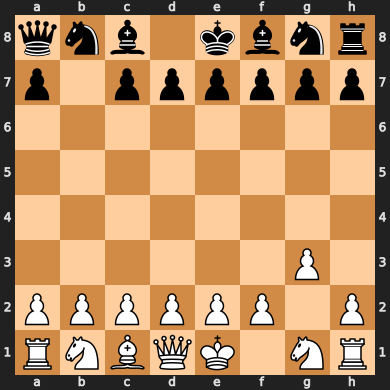

{63: Piece.from_symbol('r'), 62: Piece.from_symbol('n'), 61: Piece.from_symbol('b'), 60: Piece.from_symbol('k'), 58: Piece.from_symbol('b'), 57: Piece.from_symbol('n'), 56: Piece.from_symbol('q'), 55: Piece.from_symbol('p'), 54: Piece.from_symbol('p'), 53: Piece.from_symbol('p'), 52: Piece.from_symbol('p'), 51: Piece.from_symbol('p'), 50: Piece.from_symbol('p'), 48: Piece.from_symbol('p'), 22: Piece.from_symbol('P'), 15: Piece.from_symbol('P'), 13: Piece.from_symbol('P'), 12: Piece.from_symbol('P'), 11: Piece.from_symbol('P'), 10: Piece.from_symbol('P'), 9: Piece.from_symbol('P'), 8: Piece.from_symbol('P'), 7: Piece.from_symbol('R'), 6: Piece.from_symbol('N'), 4: Piece.from_symbol('K'), 3: Piece.from_symbol('Q'), 2: Piece.from_symbol('B'), 1: Piece.from_symbol('N'), 0: Piece.from_symbol('R')}


In [3]:
board = chess.Board(fen="qnb1kbnr/p1pppppp/8/8/8/6P1/PPPPPP1P/RNBQK1NR w KQk - 0 1")
display(board)
player = False
amount = 0
for pos, piece in board.piece_map().items():
    if piece.color == player and pos in both_diagonals:
        if piece.piece_type is chess.QUEEN or piece.piece_type is chess.BISHOP:
            amount+=1
print(board.piece_map())

## Simple Evaluation Functions

In [82]:
class EvalFunc:
    """
    each function has a name which corresponds to its row in the dataset and a function
    """
    def apply(self, board,player):
        return None

class MatSumEvalFunc(EvalFunc):
    """
        Calculates Material Sum
    """
    name = "material sum"
    def apply(self, board, player):
        mat_sum = 0
        for piece_type in list(piece_vals.keys()):
            mat_sum += (len(board.pieces(piece_type, player)) * piece_vals[piece_type])
        return mat_sum

class PieceSquaresEvalFunc(EvalFunc):
    """
       Evaluates board based on positions of pieces 
    """
    name = "piece squares sum"
    def apply(self, board,player):
        piece_map = board.piece_map()
        result = 0
        for square in list(piece_map.keys()):
            if piece_map[square].color == player :
                piece = piece_map[square]
                #print('old posn: ', square)
                square_file = square % 8

                square_rank = 7 - (square // 8)

                square_posn = 8 * square_rank + square_file
                
                if player is False:
                    square_posn = square_posn^56
                    
                #print('posn',square_posn - 1)
                
                #pawn
                if piece.piece_type is chess.PAWN:
                    result += (mg_pawn_table[square_posn] + mg_value[0])
                    #print(mg_pawn_table[square_posn])
                    
                #bishop
                elif piece.piece_type is chess.BISHOP:
                    result += (mg_bishop_table[square_posn] + mg_value[2])
                
                #knight
                elif piece.piece_type is chess.KNIGHT:
                    result += (mg_knight_table[square_posn] + mg_value[1])
                
                #queen
                elif piece.piece_type is chess.QUEEN:
                    result += (mg_queen_table[square_posn] + mg_value[4])
                    print('queen value: ', (mg_queen_table[square_posn] + mg_value[4]))
                
                #king
                elif piece.piece_type is chess.KING:
                    result += mg_king_table[square_posn]
                    print('king value: ', square_posn,(mg_king_table[square_posn]))
                    
                #rook
                elif piece.piece_type is chess.ROOK:
                    result += (mg_rook_table[square_posn] + mg_value[3])
                    print('rook value: ', (mg_rook_table[square_posn] + mg_value[3]))
        return result
class DiagonalControlEvalFunc(EvalFunc):
    """
        Evaluates board based on how many diagonals are controlled.
    """
    name = "diagonal control"
    def apply(self, board,player): 
        amount = 0
        for pos, piece in board.piece_map().items():
            if piece.color == player and pos in both_diagonals:
                if piece.piece_type is chess.QUEEN or piece.piece_type is chess.BISHOP:
                    amount+=1
        return amount
    
class CenterControlEvalFunc(EvalFunc):
    """
        Evaluates board based on how much of the center is controlled.
    """
    name = "center control"
    def apply(self, board,player):
        #4 center squares
        #attacking center squares
        amount = 0
        piece_map = board.piece_map()
        for csquare in center_squares:
            if csquare in list(piece_map.keys()) and piece_map[csquare].color == player:
                amount+=1
        return amount
    
class PawnControlEvalFunc(EvalFunc):
    """
        TODO??? pawn islands?
    """
    name = "pawn control"
    def apply(self,board,player):
        piece_map = board.piece_map()
        player = not player
        result = 0
        file_dict = dict()
        for square in list(piece_map.keys()):
            if piece_map[square].color == player and piece_map[square].piece_type == 1:
                file_dict[chess.square_file(square)] = 1 

        isPawn = False
        for file in range(8) :
            #Add an island
            if isPawn and file_dict.get(file,0) == 0 :
                result+=1
                isPawn = False
            if file_dict.get(file,0) == 1 :
                isPawn = True

        #add the last pawn island
        if isPawn :
            result +=1
        return result
    
class DoublePawnsEvalFunc(EvalFunc):
    """
        Evaluates board based on how many pawns are doubled
    """
    name = "doubled pawns"
    def apply(self,board,player):
        piece_map = board.piece_map()
        player = not player
        result = 0
        file_dict = dict()
        for square in list(piece_map.keys()):
            if piece_map[square].color == player and piece_map[square].piece_type == 1:
                if file_dict.get(chess.square_file(square),0) == 1 :
                    result+=1
                else :
                    file_dict[chess.square_file(square)] = 1 
        return result
            

class MobilityEvalFunc(EvalFunc):
    """
        Evaluates board based on how many moves the player has.
    """
    name = "mobility"
    def apply(self,board,player):
        return len(list(board.legal_moves))

class BothBishopsEvalFunc(EvalFunc):
    """
        Evaluates board based on whether or not both bishops are still on board.
    """
    name = "both bishops"
    def apply(self,board,player):
        return int(len(board.pieces(3,player)) == 2)
    
class NotAllPawnsEvalFunc(EvalFunc):
    """
        Evaluates board based on how many pawns there are. Less than 8 is better.
    """
    name = "not all pawns"
    def apply(self, board,player):
        return int(len(board.pieces(1,player)) < 8)

class PinEvalFunc(EvalFunc):
    """
        Evaluates board based on how many and of what type pieces are pinned.
    """
    name = "pinned evaluation"
    def apply(self, board,player):
        player = not player
        piece_map = board.piece_map()
        result = 0
        for square in list(piece_map.keys()):
            if piece_map[square].color == player and board.is_pinned(player, square):
                result += piece_vals.get(piece_map[square].piece_type)
        return result
    
class AttackerEvalFunc(EvalFunc):
    """
        Evaluates board based on how many and of what type pieces are attacked.
    """
    name = "attacker evalutation"
    def apply(self, board,player):
        player_other = not player
        piece_map = board.piece_map()
        result = 0
        for square in list(piece_map.keys()):
            if piece_map[square].color == player_other and board.is_attacked_by(player, square):
                result += piece_vals.get(piece_map[square].piece_type)
        return result

class HasQueenEvalFunc(EvalFunc):
    """
        Evaluates board based on whether or not the player has their queen or not.
    """
    name = "has queen"
    def apply(self, board, player):
        return len(board.pieces(chess.QUEEN,player))

EVAL_FUNC_LIST = [MatSumEvalFunc(), PawnControlEvalFunc(), PieceSquaresEvalFunc(), DiagonalControlEvalFunc(),
                 CenterControlEvalFunc(), DoublePawnsEvalFunc(), MobilityEvalFunc(), 
                  BothBishopsEvalFunc(), NotAllPawnsEvalFunc(), PinEvalFunc(),
                  AttackerEvalFunc(), HasQueenEvalFunc()]

In [83]:
func = PieceSquaresEvalFunc()
board = chess.Board(fen="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
print(func.apply(board,False))

rook value:  451
king value:  60 8
queen value:  1035
rook value:  458
3892


## Collective Evaluation Functions

In [5]:
class VectorEvaluator(EvalFunc):
    """
        Returns a list/vector where each value is a feature from the EVAL_FUNC_LIST
    """
    def apply(self, board, player):
        scores = []
        for ef in EVAL_FUNC_LIST:
            scores+=[ef.apply(board,player)]
        return scores


class NaiveSumEvaluator(EvalFunc):
    """
        Evaluates board by taking a naive sum of features.x 
    """
    def apply(self, board, player):
        score = 0
        for ef in EVAL_FUNC_LIST:
            score+=ef.apply(board,player)
            
class IntelligentEvaluator(EvalFunc):
    """
        Evaluates Board based on a machine learning model.
    """
    def __init__(self, model):  
        self.model = model
    def apply(self, board, player):
        pass
        
    

## Utility Functions               

In [6]:
def get_samples(pgn_string):   
    """
        This function will take in a pgn_string, extract all the moves played, and then randomly
        sample 10% of the game states and return these states as fen strings.
    """
    pgn = io.StringIO(pgn_string)
    game = chess.pgn.read_game(pgn)
    
    moves = list(game.mainline_moves())
    
    num_moves = len(moves)
    
    num_samples = num_moves // 5
    
    samples = []
    sample_indices = random.sample(range(num_moves), k=num_samples)
    board = chess.Board()
    for i in range(len(moves)):
        move = moves[i]
        board.push(move)
        if i in sample_indices:
            samples.append(board.fen())
    
    return samples, sample_indices, num_moves  

def get_winner(pgn):
    """
        Returns winner of this game or "Draw" if the game ended in a draw.
    """
    
    start = pgn.index("Result") + 8
    end = pgn.index("]", start) -1
    result = pgn[start:end]
    if result == "1-0":
        return "White"
    elif result == "0-1":
        return "Black"
    elif result == "1/2-1/2":
        return "Draw"
    else:
        raise Exception("Bad result")

def get_column_names():
    eval_funcs_white = [("W_" + ef.name) for ef in EVAL_FUNC_LIST]
    eval_funcs_black = [("B_" + ef.name) for ef in EVAL_FUNC_LIST]

    cols = ["fen", "winner", "move number", "total moves"]
    cols.extend(eval_funcs_white)
    cols.extend(eval_funcs_black)
    return cols
    

In [7]:
#iterating over games dataset, to create state datast
def populate(games, num_workers):
    """
        For each game, this function will sample 10% of the states and evaluate the features and return
        a DataFrame where each row corresponds to a state and its associated features. It will use
        multiprocessing based on the num_workers argument which will specify how many processes to use.
    
    """
    
    def split(df, n):
        """
            Splits this dataframe into a list of n dataframes for parallel processing
        """
        result = []
        increment = len(df)//n
        current_index = increment
        result.append(df[:current_index])
        for i in range(n-2):
            df_new = df[current_index: current_index + increment]
            current_index+=increment
            result.append(df_new)
        result.append(df[current_index:])
        return result

    
    
    def populate_helper(procnum, df_in, return_dict):
        """
            Iterates over all the games in df_in, samples 10% of the states, and then evaluates all the features.
            It then puts the result datframe in return_dict.
        """
        evaluator = VectorEvaluator()
        result = pd.DataFrame(columns=get_column_names())
        for i in tqdm(range(len(df_in))):
#         for i in range(len(df_in)):
            pgn_string = df_in.iloc[i][1]
            try:
                winner = get_winner(pgn_string)
                samples, sample_indices, num_moves = get_samples(pgn_string)
                for i in range(len(samples)):  
                    if samples[i] not in result["fen"]:
                        column_values = []
                        column_values.append(samples[i])
                        column_values.append(winner)
                        column_values.append(sample_indices[i])
                        column_values.append(num_moves)
                        board = chess.Board(fen=samples[i])
                        eval_scores_white = evaluator.apply(board, WHITE)
                        eval_scores_black = evaluator.apply(board, BLACK)
                        diff = [eval_scores_white[i] - eval_scores_black[i] for i in range(len(eval_scores_white))]
#                         column_values.extend(eval_scores_white)
#                         column_values.extend(eval_scores_black)
                        result.loc[len(result.index), "White"] = eval_scores_white
                        result.loc[len(result.index), "Black"] = eval_scores_black
                        result.loc[len(result.index), "Differene"] = diff

        
                    else:
                        print("dup found")
            except Exception as inst:
                    print(inst)  
                    print("Error", i)
                    
        return_dict[procnum] = result
        return
    
    
    
    
    games_list = split(games, num_workers)
    jobs = []
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    #these are the processes being started
    for i in range(num_workers):
        p = multiprocessing.Process(target=populate_helper, args=(i, games_list[i], return_dict))
        jobs.append(p)
        p.start()
    #waiting for the processes to finish
    for proc in jobs:
        proc.join()

    #building the final complete dataframe from the parallel dataframes
    final_df = pd.DataFrame(columns=get_column_names())
    for i in range(num_workers):
        final_df = final_df.append(return_dict[i])

    return final_df.reset_index(drop=True) 
    

In [8]:
start_time = time.time()
df_pgn = pd.read_csv("chess_games.csv")
df_pgn = df_pgn.sample(50)
df_eval = populate(df_pgn, NUM_PROCESSES)
time = time.time() - start_time
print(time, "seconds")
print(time // 60, "minutes")
df_eval

df_eval.to_csv("evaluations.csv")

AttributeError: Can't pickle local object 'populate.<locals>.populate_helper'

In [ ]:
# (159079 - len(df_eval["fen"].unique())) / 159079
# df_eval[df_eval.duplicated(keep="first")]["fen"].iloc[0]
df_eval[df_eval["fen"] == 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1']

In [ ]:
# total = len(df_eval["winner"])
# print("Total: ", total)
# white = len(df_eval[df_eval["winner"] == "White"])
# print("white: ", white/total)
# draw = len(df_eval[df_eval["winner"] == "Draw"])
# print("draw: ", draw/total)
# black = len(df_eval[df_eval["winner"] == "Black"])
# print("black: ", black/total)



## Notes

In [ ]:
#is in check, pins/discoveries, attackers, can castle, 


#once dataset is finalized:
#exploratory data analysis, plot correlations, feature elimination?
#regression, or classification


#ignore opening move

In [ ]:


# import chess
# import chess.engine
# from IPython.display import SVG, display

# engine = chess.engine.SimpleEngine.popen_uci("/usr/local/bin/stockfish")

# board = chess.Board()
# while not board.is_game_over():
#     display(board)
#     result = engine.play(board, chess.engine.Limit(time=1))
#     board.push(result.move)

# engine.quit()